In [1]:
from fastai import *
import networkx as nx
from IPython.display import Image, display

import dis
from collections import defaultdict

import fastai

In [2]:
path = Path(fastai.__file__).parent
print(path)

/anaconda3/lib/python3.7/site-packages/fastai


## Explore the python files in the fastai source tree.  

In [3]:
def all_files(p:Path) -> Collection[Path]:
    "Recursively scan path for all files"
    return sum(map(all_files, p.ls()), []) if p.is_dir() else [p]


def filtered_files(p:Path, not_string="__pycache__", in_string=".py") -> Collection[Path]:
    "Call all_files and filter results for exclusion and inclusion of string"
    return list(filter(lambda x: 
                       (not_string not in str(x)) and 
                       (in_string in str(x)), 
                       all_files(p)))

In [4]:
paths = filtered_files(path)
[str(x).split(str(path)+"/")[1] for x in paths]

['callback.py',
 'metrics.py',
 'torch_core.py',
 'version.py',
 'callbacks/hooks.py',
 'callbacks/mixup.py',
 'callbacks/general_sched.py',
 'callbacks/fp16.py',
 'callbacks/lr_finder.py',
 'callbacks/__init__.py',
 'callbacks/csv_logger.py',
 'callbacks/tracker.py',
 'callbacks/one_cycle.py',
 'callbacks/rnn.py',
 'basic_train.py',
 'tabular/models.py',
 'tabular/__init__.py',
 'tabular/transform.py',
 'tabular/data.py',
 'datasets.py',
 '__init__.py',
 'core.py',
 'utils/collect_env.py',
 'utils/__init__.py',
 'vision/tta.py',
 'vision/__init__.py',
 'vision/models/unet.py',
 'vision/models/__init__.py',
 'vision/models/darknet.py',
 'vision/models/wrn.py',
 'vision/transform.py',
 'vision/image.py',
 'vision/data.py',
 'vision/learner.py',
 'imports/__init__.py',
 'imports/core.py',
 'imports/torch.py',
 'basic_data.py',
 'collab.py',
 'train.py',
 'data_block.py',
 'text/models.py',
 'text/qrnn/__init__.py',
 'text/qrnn/forget_mult.py',
 'text/qrnn/qrnn.py',
 'text/__init__.py',
 

### Simplify the list of files

We will simplify the remaining analysis and only include the path.name

text/models.py, tabular/models.py get projected to models.py

We are left with only 39 distinct filenames if we also exclude `__init__.py`

In [5]:
len([x.name for x in paths]), len({x.name for x in paths if x.name != '__init__.py'})

(58, 39)

In [6]:
def imports_in_file(p:Path) -> Collection[str]:
    "Return the list of imports from python file `p`"
    instructions = dis.get_instructions(open(p).read())
    return [x.argval for x in instructions if ("IMPORT_NAME" in x.opname)]

In [7]:
dependencies = defaultdict(set)
for x in paths:
    if x.name != '__init__.py':
        dependencies[x.name.split('.py')[0]].update(imports_in_file(x))
len(dependencies), list(dependencies.items())[:3]

(39,
 [('callback', {'basic_data', 'torch_core'}),
  ('metrics', {'callback', 'torch_core'}),
  ('torch_core', {'core', 'imports.torch'})])

In [8]:
p_dependencies = defaultdict(set)
for x, y in dependencies.items():
    for z in y:
        p_dependencies[x].add(z.split('.')[-1])
len(p_dependencies), list(p_dependencies.items())[:4]

(38,
 [('callback', {'basic_data', 'torch_core'}),
  ('metrics', {'callback', 'torch_core'}),
  ('torch_core', {'core', 'torch'}),
  ('hooks', {'basic_data', 'basic_train', 'callback', 'torch_core'})])

In [9]:
set(dependencies.keys()).difference(set(p_dependencies.keys()))

{'version'}

## Let's visualize these dependencies

In [10]:
DG = nx.DiGraph()
keys = set(p_dependencies.keys())
for x, y in p_dependencies.items():
    for z in y: 
        if z in keys and x != z:
            DG.add_edge(x, z) 

In [11]:
DG.number_of_nodes(), DG.number_of_edges()

(37, 109)

### PyDot to the rescue

In [12]:
#  From https://stackoverflow.com/questions/4596962/display-graph-without-saving-using-pydot
def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

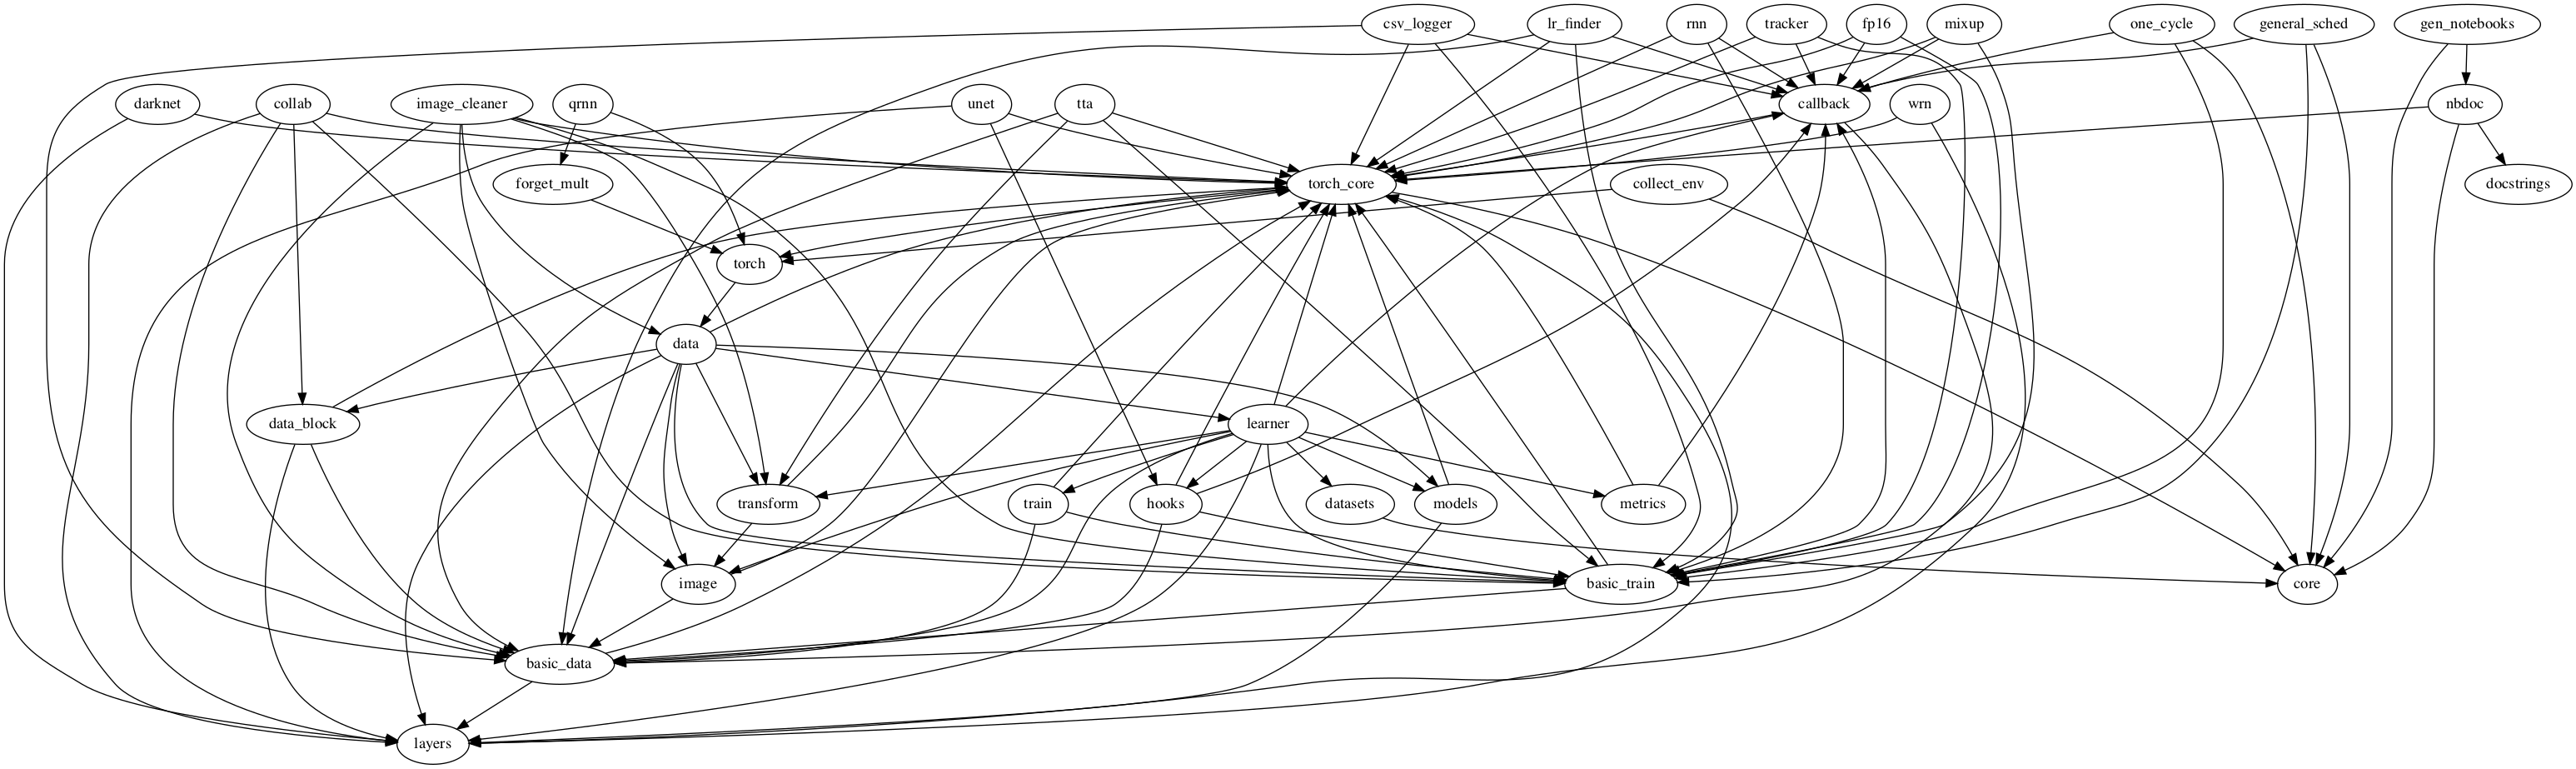

In [13]:
viewPydot(nx.drawing.nx_pydot.to_pydot(DG))

The most important modules to learn are those that are used by others

In [14]:
key_modules = [x for x,y in Counter(y for x,y in DG.edges).most_common() if y>=1]
star_modules = [x for x,y in Counter(y for x,y in DG.edges).most_common() if y>=3]
key_modules, star_modules

(['torch_core',
  'basic_train',
  'basic_data',
  'callback',
  'layers',
  'core',
  'torch',
  'image',
  'transform',
  'data',
  'models',
  'data_block',
  'hooks',
  'learner',
  'metrics',
  'datasets',
  'train',
  'forget_mult',
  'docstrings',
  'nbdoc'],
 ['torch_core',
  'basic_train',
  'basic_data',
  'callback',
  'layers',
  'core',
  'torch',
  'image',
  'transform'])

In [15]:
pdot = nx.drawing.nx_pydot.to_pydot(DG)
for i, node in enumerate(pdot.get_nodes()):
    if str(node).strip(";") in star_modules:
        node.set_shape('egg')
        node.set_style('filled')
        node.set_fillcolor('#66c2a5')
    elif str(node).strip(";") in key_modules:
        node.set_shape('ellipse')
        node.set_style('filled')
        node.set_fillcolor('#fc8d62')
    else:
        node.set_shape('box')
        node.set_style('filled')
        node.set_fillcolor('#8da0cb')

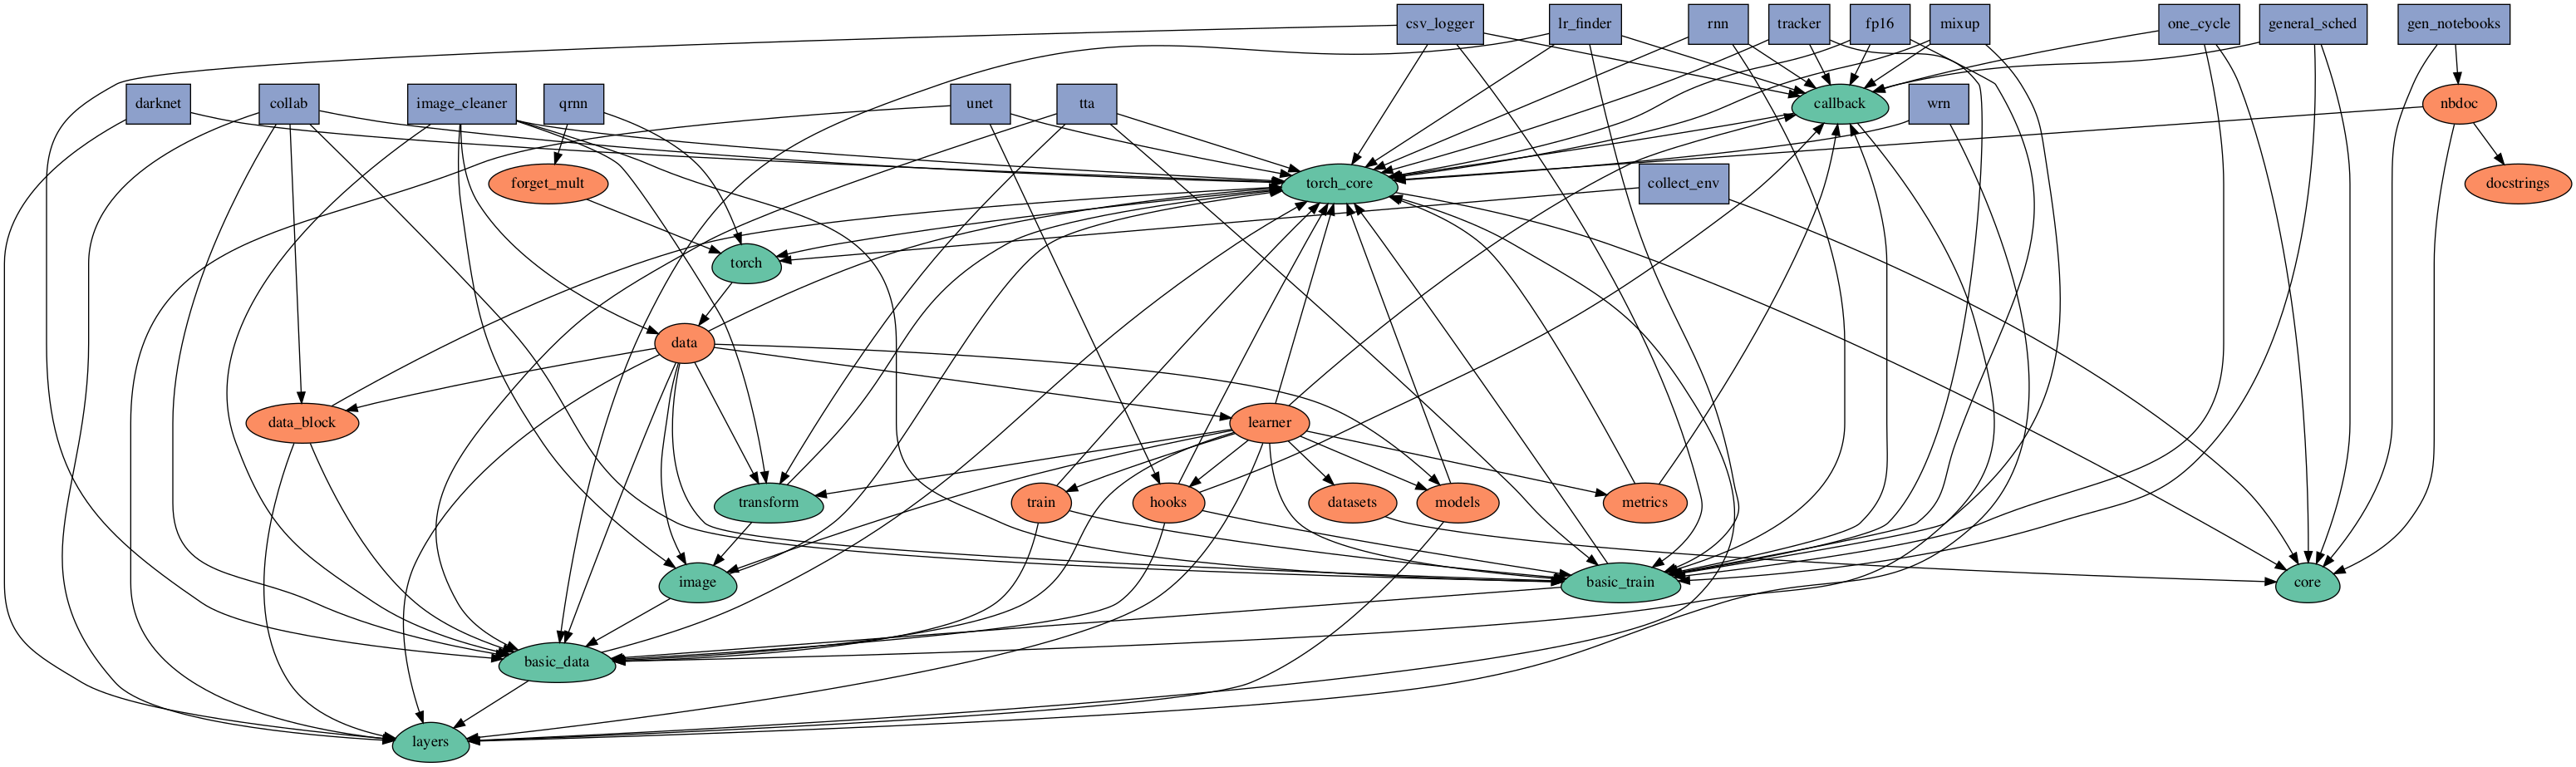

In [16]:
viewPydot(pdot)

In [17]:
pdot.write_png("/tmp/fastai_simplified_deps.png")

### supplementary attempts to plot dependencies without pydot

The default matplotlib visualization of networkx results in a mess; I didn't try very hard after I got pydot to work.

In [ ]:
_, ax = plt.subplots(figsize=(12.9*1.2,8*1.2))
nx.draw(DG, with_labels=True, ax=ax)

In [ ]:
_, ax = plt.subplots(figsize=(12.9*1.2,8*1.2))
nx.draw(DG, pos=nx.kamada_kawai_layout(DG), 
        with_labels=True, ax=ax)

It's hard to improve it with graphviz (conda install pygraphviz)

In [ ]:
_, ax = plt.subplots(figsize=(12.9*1.2,8*1.2))
nx.draw(DG, pos=nx.nx_agraph.graphviz_layout(DG, prog="fdp"), 
        with_labels=True, node_size=500, ax=ax)

This one looks a little better

In [ ]:
_, ax = plt.subplots(figsize=(12.9*1.5,8*1.5))
nx.draw(DG, pos=nx.nx_agraph.graphviz_layout(DG, prog="dot"),
        with_labels=True, node_size=1500,
        ax=ax,
       )

In [ ]:
_, ax = plt.subplots(figsize=(12.9*2,8*2))
nx.draw(DG, pos=nx.nx_agraph.graphviz_layout(DG, prog="neato"),
        with_labels=True, node_size=1500,
        ax=ax,
       )